In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
from functions import preproc_nemo
from functions import dateDecimal
from functions import moving_average
from functions import linear_fit
expname='beta'
expdir=os.path.join('/ec/res4/scratch/itas/ece4/', expname, 'output', 'nemo')

In [2]:
domain = xr.open_dataset(os.path.join(expdir, '..', '..', 'domain_cfg.nc'))
vol = domain['e1t']*domain['e2t']*domain['e3t_0']
area = domain['e1t']*domain['e2t']
sect = domain['e2t']*domain['e3t_0']
dz = domain['e3t_0']

In [3]:
mask = xr.open_dataset(os.path.join(expdir, '..', '..', 'maskutil.nc'))
mask

<xarray.Dataset>
Dimensions:    (t: 1, y: 331, x: 360)
Dimensions without coordinates: t, y, x
Data variables:
    tmaskutil  (t, y, x) int8 ...
    umaskutil  (t, y, x) int8 ...
    vmaskutil  (t, y, x) int8 ...
Attributes:
    Conventions:  CF-1.1

In [30]:
start_year = 1990
end_year = 2090
filelist = []
for year in range(start_year, end_year + 1):
    pattern = os.path.join(expdir, f"{expname}_oce_1m_T_{year}-{year}.nc")
    matching_files = glob.glob(pattern)
    filelist.extend(matching_files)
data = xr.open_mfdataset(filelist, preprocess=preproc_nemo)
data

<xarray.Dataset>
Dimensions:               (y: 331, x: 360, time: 1212, z: 75, axis_nbounds: 2)
Coordinates:
    nav_lat_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1990-01-16T12:00:00 ... 2090-...
  * z                     (z) float32 -0.5 -1.55 ... -5.698e+03 -5.902e+03
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/25)
    deptht_bounds         (time, z, axis_nbounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    e3t                   (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    to                    (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    so                    (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    ...                    ...
    qt_oce                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sfx                   (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    taum                  (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    windsp                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    precip                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    snowpre               (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    name:         output/nemo/beta_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2023-Oct-20 14:50:50 GMT
    uuid:         41f17b0e-e220-4e91-b7ec-69f660c4d6e0

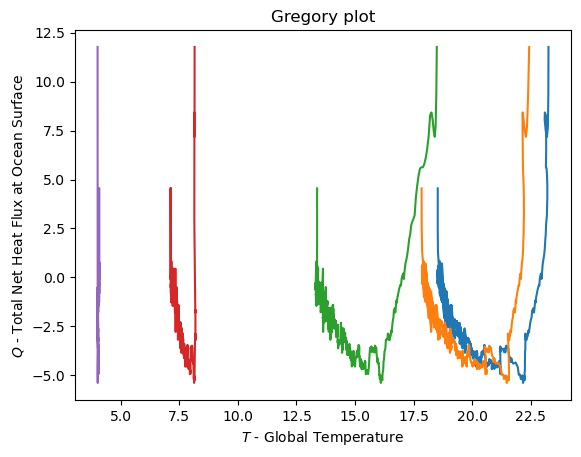

In [31]:
# gregory plot
zf=len(data['z'].values)
fig, ax = plt.subplots()
for zz in range(0,zf-1,15):
    to = moving_average(data.to.isel(z=zz).mean(dim=['y', 'x']).values.flatten(),12)
    qt = moving_average(data.qt_oce.weighted(area).mean(dim=['y', 'x']).values.flatten(),12)
    ax.plot(to,qt)
plt.xlabel(r'$T$ - Global Temperature ')
plt.ylabel(r'$Q$ - Total Net Heat Flux at Ocean Surface')
plt.title('Gregory plot')
plt.show()

In [ ]:
Xd = thetao_gns
Yd = qt_gns
#print(Xd)
X1 = 6.65; X2 = 6.93
#mp, qp = linear_fit(Xd, Yd, X1, X2)
Xr=[]; Yr=[]
for i in range(len(Xd)):
    if ((Xd[i] >= X1) and (Xd[i]<= X2)):
        Xr.append(Xd[i])
        Yr.append(Yd[i])
Xr = np.array(Xr)
Yr = np.array(Yr)
Xg = [[Xr[i]] for i in range(len(Xr))]
Yg = [[Yr[i]] for i in range(len(Yr))]
model=LinearRegression()
model.fit(Xg, Yg)
mp = model.coef_[0][0]
qp = model.intercept_[0]
print(mp,qp)
Yr1 = [mp*Xr[i]+qp for i in range(len(Xr))]

In [ ]:
# gregory plot + fit
yrs=(len(thetao_gns) - 1)
colormap = plt.get_cmap('viridis')
colors = [colormap(i / yrs) for i in range(yrs)]
fig, ax = plt.subplots()
for i in range(yrs):
    ax.plot(thetao_gns[i:i+2], qt_gns[i:i+2], color=colors[i])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(0, yrs))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('time')
plt.xlabel(r'$T$ - Global Temperature ')
plt.ylabel(r'$Q$ - Total Net Heat Flux at Ocean Surface')
plt.title('Gregory plot')
plt.plot(Xr,Yr1)
plt.show()

In [ ]:
xr0 = -qp/mp
print(xr0)

In [15]:
zd = data.z.values 
print(zd[74])

5902.0356


In [21]:
for field in ['thetao', 'so']:
    locals()[field] = (data[field] * vol).mean(dim=['z', 'y', 'x'])

In [27]:
mdata = {}
mlist = {}

for field in ['tos', 'sos']:
    mdata[f'{field}g'] = data[f'{field}'].weighted(area).mean(dim=['y', 'x']).values.flatten()

print(mdata['tosg'][0])

23.725995726306746
